In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils import load_anything, get_basename, path_of, norm, float_to_uint16, care_align, quantile_image, quantile_image_minmax, hill, mip, upsample3d, iou, iou_cuda, get_best_iou
import tifffile
import torch
import torch.nn.functional as F

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [2]:
base = "_results_for_paper"

# fig. 4 beads data

In [3]:
idx = 3
original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))
care       = tifffile.imread(path_of(base, "fig4", "care", idx))
deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear", idx))
tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

In [4]:
print("original   ", original  .shape) 
print("care       ", care      .shape) 
print("deconv     ", deconv    .shape) 
print("neuroclear ", neuroclear.shape) 
print("tenet      ", tenet     .shape) 

original    (1, 24, 128, 128)
care        (310, 512, 512)
deconv      (24, 128, 128)
neuroclear  (310, 512, 512)
tenet       (240, 128, 128)


In [5]:
rois = [
    {'image': 0,  'zmid': 15, 'xmid': 342, 'ymid': 299, 'model_id':0},
    {'image': 4,  'zmid': 12, 'xmid': 262, 'ymid': 252, 'model_id':0},
    {'image': 5,  'zmid': 13, 'xmid': 199, 'ymid': 291, 'model_id':0},
    {'image': 6,  'zmid': 12, 'xmid': 238, 'ymid': 268, 'model_id':1},
    {'image': 6,  'zmid': 12, 'xmid': 342, 'ymid': 150, 'model_id':1},
    {'image': 7,  'zmid': 12, 'xmid': 278, 'ymid': 205, 'model_id':1},
    {'image': 8,  'zmid': 12, 'xmid': 290, 'ymid': 219, 'model_id':2},
    {'image': 9,  'zmid': 12, 'xmid': 273, 'ymid': 235, 'model_id':2},
    {'image': 10, 'zmid': 12, 'xmid': 286, 'ymid': 224, 'model_id':2},
    {'image': 11, 'zmid': 13, 'xmid': 323, 'ymid': 231, 'model_id':3},
    {'image': 12, 'zmid': 13, 'xmid': 296, 'ymid': 202, 'model_id':3},
    {'image': 13, 'zmid': 13, 'xmid': 293, 'ymid': 244, 'model_id':3},
    {'image': 14, 'zmid': 17, 'xmid': 249, 'ymid': 190, 'model_id':4},
    {'image': 15, 'zmid': 12, 'xmid': 246, 'ymid': 254, 'model_id':4},
    {'image': 16, 'zmid': 12, 'xmid': 272, 'ymid': 225, 'model_id':4},
    {'image': 17, 'zmid': 12, 'xmid': 298, 'ymid': 224, 'model_id':5},
    {'image': 18, 'zmid': 12, 'xmid': 288, 'ymid': 215, 'model_id':5},
    {'image': 18, 'zmid': 12, 'xmid': 275, 'ymid': 442, 'model_id':5},
    {'image': 22, 'zmid': 17, 'xmid': 286, 'ymid': 221, 'model_id':6},
    {'image': 23, 'zmid': 17, 'xmid': 254, 'ymid': 256, 'model_id':6},
    {'image': 24, 'zmid': 17, 'xmid': 258, 'ymid': 283, 'model_id':6},
    {'image': 26, 'zmid': 17, 'xmid': 159, 'ymid': 285, 'model_id':7},
    {'image': 27, 'zmid': 16, 'xmid': 233, 'ymid': 201, 'model_id':7},
    {'image': 28, 'zmid': 15, 'xmid': 345, 'ymid': 119, 'model_id':7},
    {'image': 28, 'zmid': 16, 'xmid': 236, 'ymid': 285, 'model_id':8},
    {'image': 28, 'zmid': 16, 'xmid': 236, 'ymid': 285, 'model_id':8},
    {'image': 29, 'zmid': 15, 'xmid': 341, 'ymid': 147, 'model_id':8},
    {'image': 29, 'zmid': 15, 'xmid': 277, 'ymid': 274, 'model_id':9},
    {'image': 30, 'zmid': 16, 'xmid': 144, 'ymid': 306, 'model_id':9},
    {'image': 30, 'zmid': 15, 'xmid': 422, 'ymid': 421, 'model_id':9}
    ]



In [6]:
# crop care and care data
dire = os.path.join(base, "fig4" ,"care")
dire2 = os.path.join(base, "fig4" ,"care2")
count = 0
for model_id in range(10):
    im_list = sorted([i for i in os.listdir(dire) if "_" + str(model_id) in i])
    roi_list = rois[model_id*3:(model_id+1)*3]
    for roi in roi_list:
        image = tifffile.imread(
            os.path.join(
                dire,
                str(roi["image"]).zfill(2)+"_"+str(model_id)+".tif"))
        image = care_align(image)
        roiarray = image[roi["zmid"]*10-120:roi["zmid"]*10+120,
                         roi["xmid"] - 64  :roi["xmid"] + 64,
                         roi["ymid"] - 64  :roi["ymid"] + 64,]
        tifffile.imwrite(dire2 + f"/{str(count).zfill(3)}.tiff", roiarray)  
        count += 1    


_results_for_paper/fig4/neuroclear3/000.tif
_results_for_paper/fig4/neuroclear3/001.tif
_results_for_paper/fig4/neuroclear3/002.tif
_results_for_paper/fig4/neuroclear3/003.tif
_results_for_paper/fig4/neuroclear3/004.tif
_results_for_paper/fig4/neuroclear3/005.tif
_results_for_paper/fig4/neuroclear3/006.tif
_results_for_paper/fig4/neuroclear3/007.tif
_results_for_paper/fig4/neuroclear3/008.tif
_results_for_paper/fig4/neuroclear3/009.tif
_results_for_paper/fig4/neuroclear3/010.tif
_results_for_paper/fig4/neuroclear3/011.tif
_results_for_paper/fig4/neuroclear3/012.tif
_results_for_paper/fig4/neuroclear3/013.tif
_results_for_paper/fig4/neuroclear3/014.tif
_results_for_paper/fig4/neuroclear3/015.tif
_results_for_paper/fig4/neuroclear3/016.tif
_results_for_paper/fig4/neuroclear3/017.tif
_results_for_paper/fig4/neuroclear3/018.tif
_results_for_paper/fig4/neuroclear3/019.tif
_results_for_paper/fig4/neuroclear3/020.tif
_results_for_paper/fig4/neuroclear3/021.tif
_results_for_paper/fig4/neurocle

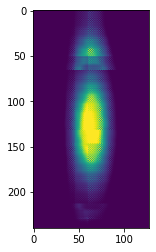

65535
0
1351.6002014160156


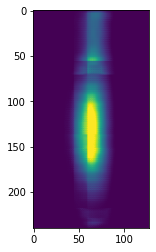

65535
0
1922.2738794962565


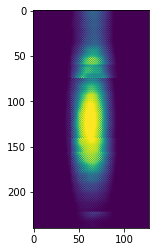

65535
0
1672.6528368631998


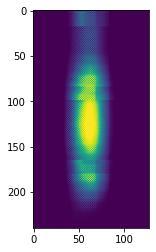

65535
0
1678.5727264404297


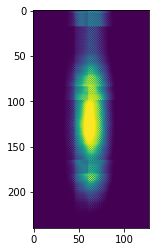

65535
0
1876.4780064900717


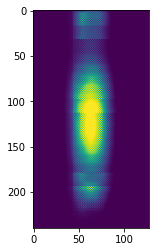

65535
0
1971.0839093526204


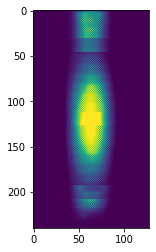

65535
0
1896.6675768534342


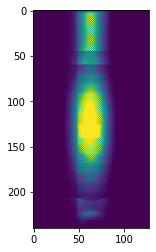

65535
0
2017.4986267089844


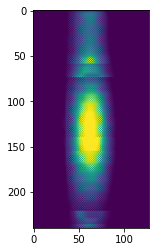

65535
0
1650.3435656229656


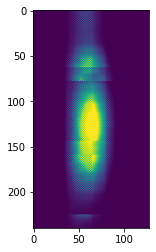

65535
0
2020.7450337727864


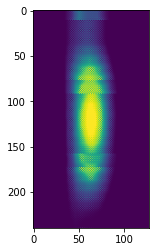

65535
0
1696.2161359151205


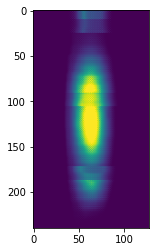

65535
0
1285.3312581380208


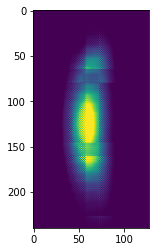

65535
0
1056.5064086914062


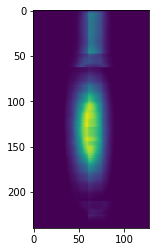

65535
0
1760.7872062683105


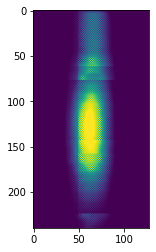

65535
0
1814.9428403218587


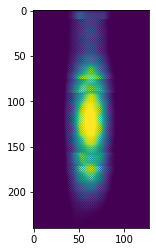

65535
0
1934.4138982137044


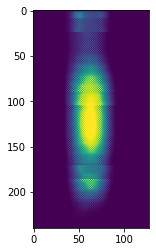

65535
0
1766.3192286173503


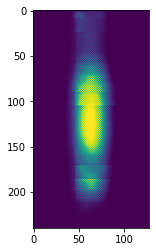

65535
0
1334.2312494913738


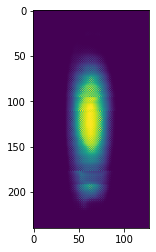

65535
0
817.2057528177897


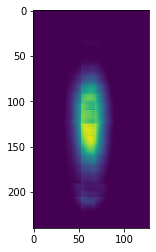

65535
0
1418.9854817708333


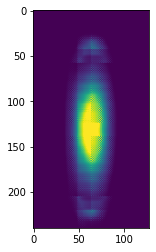

65535
0
1652.4313967386881


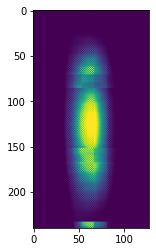

65535
0
1836.7536829630533


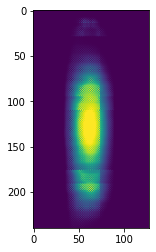

65535
0
2007.7710678100586


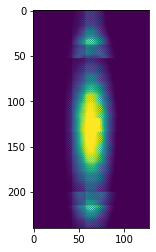

65535
0
1745.3158831278483


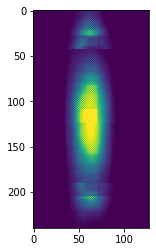

65535
0
1745.3158831278483


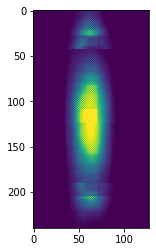

65535
0
1721.987501525879


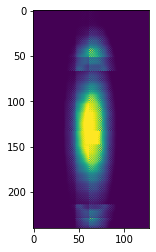

65535
0
1600.15279973348


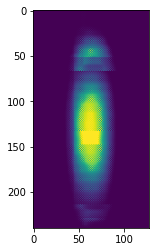

65535
0
1563.1064951578776


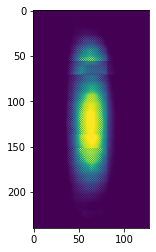

65535
0
1378.4002217610678


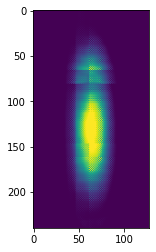

In [7]:
itera = 20000
path =  f"_results_for_paper/fig4/test_latest_iter{itera}/volumes/output_volume_xy-view_iter-{itera}.tif"
image = tifffile.imread(path)
for i in range(31):
    print(f"_results_for_paper/fig4/neuroclear3/{str(i).zfill(3)}.tif")
    tifffile.imwrite(f"_results_for_paper/fig4/neuroclear3/{str(i).zfill(3)}.tif", image[i*310:(i+1)*310])

dire = os.path.join(base, "fig4" ,"neuroclear3")
dire2 = os.path.join(base, "fig4" ,"neuroclear3_roi")
count = 0

im_list = sorted(os.listdir(dire))
for roi in rois:
    image = tifffile.imread(
        os.path.join(
            dire,
            str(roi["image"]).zfill(3)+".tif"))

    roiarray = image[roi["zmid"]*10-120:roi["zmid"]*10+120,
                     roi["xmid"] - 64  :roi["xmid"] + 64,
                     roi["ymid"] - 64  :roi["ymid"] + 64,]
    tifffile.imwrite(dire2 + f"/{str(count).zfill(3)}.tiff", roiarray)  
    count += 1    

for i in range(30):
    image = tifffile.imread(os.path.join(dire2, sorted(os.listdir(dire2))[i]))
    print(image.max())
    print(image.min())
    print(image.mean())
    plt.imshow(image[:, :, 64])
    plt.show()

65535
0
1630.0917098999023


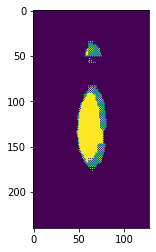

65535
0
1351.6002014160156


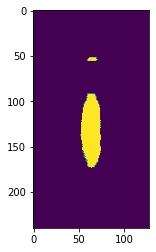

65535
0
1922.2738794962565


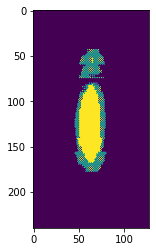

65535
0
1672.6528368631998


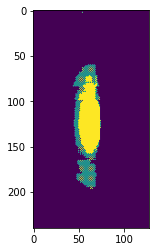

65535
0
1678.5727264404297


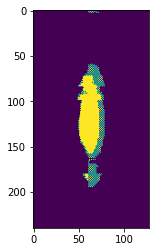

65535
0
1876.4780064900717


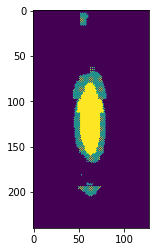

65535
0
1971.0839093526204


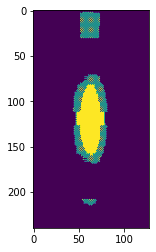

65535
0
1896.6675768534342


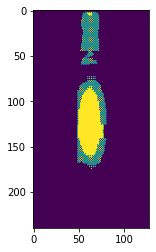

65535
0
2017.4986267089844


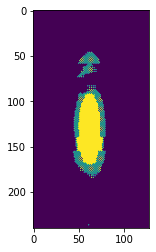

65535
0
1650.3435656229656


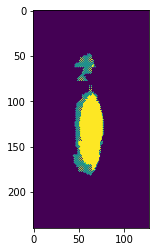

65535
0
2020.7450337727864


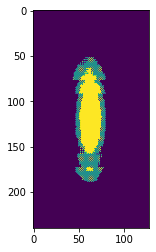

65535
0
1696.2161359151205


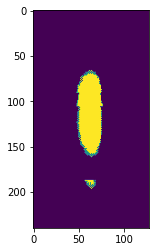

65535
0
1285.3312581380208


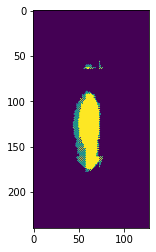

65535
0
1056.5064086914062


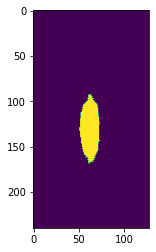

65535
0
1760.7872062683105


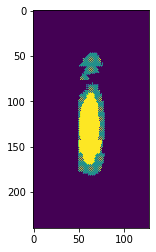

65535
0
1814.9428403218587


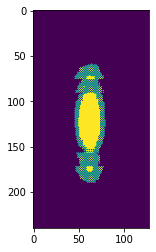

65535
0
1934.4138982137044


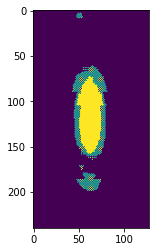

65535
0
1766.3192286173503


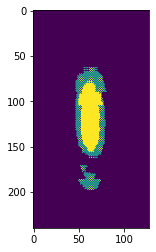

65535
0
1334.2312494913738


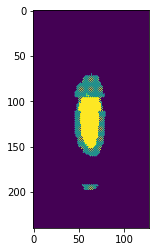

65535
0
817.2057528177897


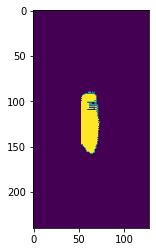

65535
0
1418.9854817708333


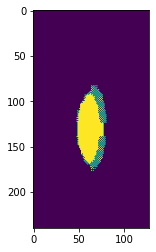

65535
0
1652.4313967386881


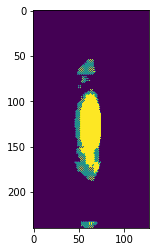

65535
0
1836.7536829630533


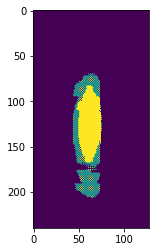

65535
0
2007.7710678100586


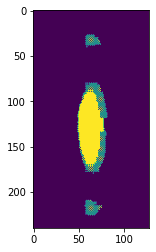

65535
0
1745.3158831278483


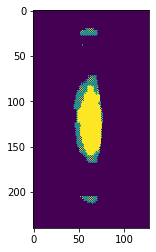

65535
0
1745.3158831278483


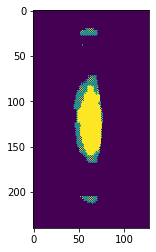

65535
0
1721.987501525879


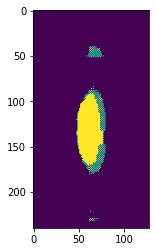

65535
0
1600.15279973348


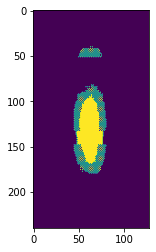

65535
0
1563.1064951578776


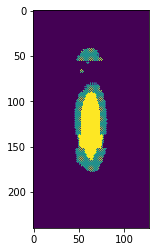

65535
0
1378.4002217610678


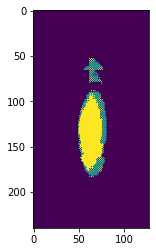

In [8]:
for i in range(30):
    image = tifffile.imread(os.path.join(dire2, sorted(os.listdir(dire2))[i]))
    print(image.max())
    print(image.min())
    print(image.mean())
    plt.imshow(image[:, :, 64]>0.6*(2**16-1))
    plt.show()

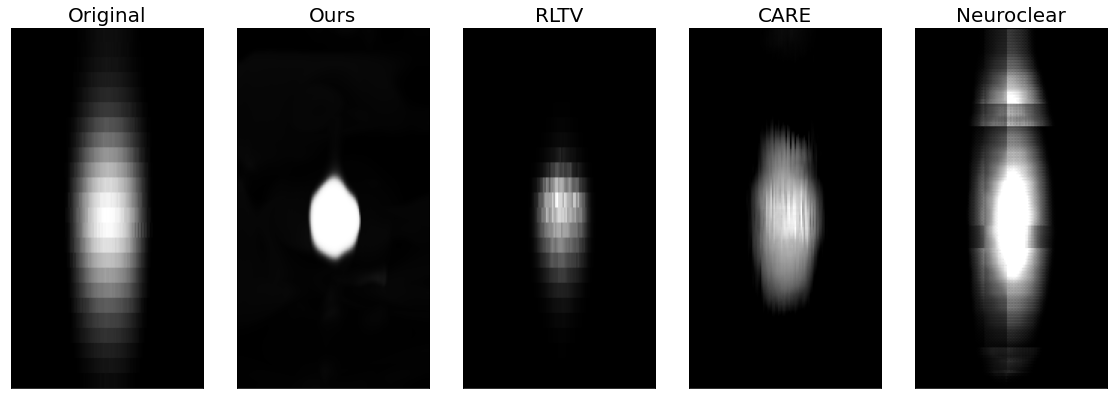

In [10]:
def figure_4a(figures  ,
               sec     ,
               start   ,
               range   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    ylabels = ["",]
    gs = gridspec.GridSpec(3, len(figures), figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        for j, img in enumerate(figure[0]):
            ax = fig.add_subplot(gs[j, i])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_title(label=figure[1], fontsize=fontsize)
            
            if i == 0:
                ax.set_ylabel(ylabels[j], fontsize=fontsize)
            
            image_to_show = mip(img        ,
                                sec=sec    ,
                                start=start,
                                range=range,
                                )
            
            #if figure[1] == "Ours":
            #    image_to_show = image_to_show > 0.5
            #if figure[1] == "RLTV":
            #    image_to_show = image_to_show > 0.2
            #if figure[1] == "CARE":
            #    image_to_show = image_to_show > 0.5
            #if figure[1] == "neuroclear":
            #    image_to_show = image_to_show > 0.5

            ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                      cmap="gray")

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig

idx = 0
original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

# preprocess to 0 to 1
original    = upsample3d(norm(original  , bit=16), scale=10)
deconv      = upsample3d(deconv/deconv.max(), scale=10)
neuroclear  = norm(neuroclear, bit=16)
care       /= care.max()
tenet       = tenet

figures = [
    [[original  ], "Original"    ],
    [[tenet     ], "Ours"        ],
    [[deconv    ], "RLTV"        ],
    [[care      ], "CARE"        ],
    [[neuroclear], "Neuroclear"  ],
]

# functions to generate
fig4a = figure_4a(
    figures,
    sec="xz",
    start=0,
    range=128,
    x_start=0,
    x_end=128,
    y_start=0,
    y_end=256,
    figsize=(16, 16),
    fontsize=20,
    figname="test",
    )

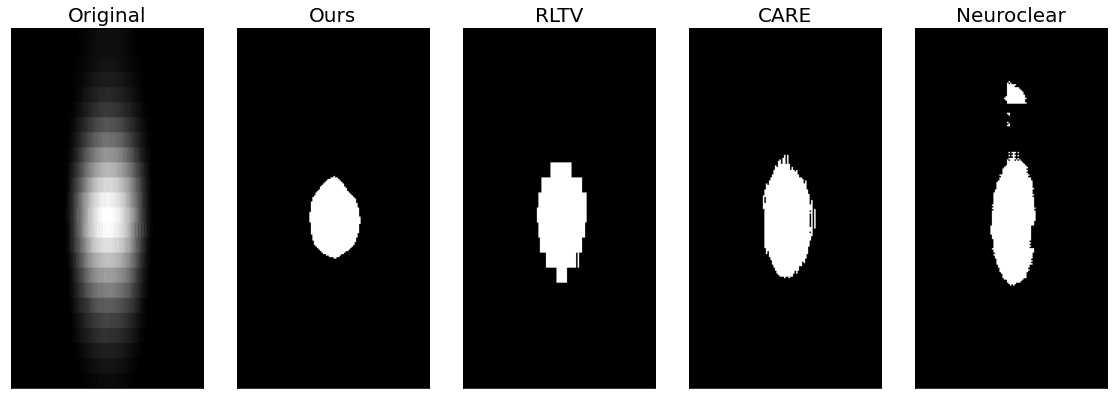

In [11]:
idx = 0
original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

# preprocess to 0 to 1
original    = upsample3d(norm(original  , bit=16), scale=10)
deconv      = upsample3d(deconv/deconv.max(), scale=10) > 0.2
neuroclear  = norm(neuroclear, bit=16) > 0.7
care       /= care.max()
care        = care > 0.5
tenet       = tenet > 0.5

figures = [
    [[original  ], "Original"    ],
    [[tenet     ], "Ours"        ],
    [[deconv    ], "RLTV"        ],
    [[care      ], "CARE"        ],
    [[neuroclear], "Neuroclear"  ],
]

# functions to generate
fig4a = figure_4a(
    figures,
    sec="xz",
    start=0,
    range=128,
    x_start=0,
    x_end=128,
    y_start=0,
    y_end=256,
    figsize=(16, 16),
    fontsize=20,
    figname="test",)

In [12]:
from skimage.measure import marching_cubes, mesh_surface_area

def sphericity(arr, threshold):
    verts, faces, _, _ = marching_cubes(arr, threshold)
    surface = mesh_surface_area(verts, faces)
    volume  = np.sum(arr>threshold)
    return pow(np.pi, 1/3) * pow(6 * volume, 2/3) / surface # Sphericity by wadell, 1935

#sphericity(tenet, 0.5)

def z_xy_ratio(arr, threshold):
    '''
    arr ; 3d array with dim [z,x,y]
    Calculate the z/xy diameter ratio
    From the slice with maximum xy area, calculate the diameter assuming it is circular
    For z, use the length from the lowest to highest slice containing voxels above the threshold
    '''
    num_z_stack = arr.shape[0]
    lowest  = -1
    highest = -1
    max_area = 0
    for height in range(num_z_stack):
        z_slice = arr[height]
        area = np.sum(z_slice > threshold)
        if area > 0:
            if lowest == -1:
                lowest = height
            highest = height
            
            if area > max_area:
                max_area = area

    z_extent = highest - lowest + 1
    xy_diameter = 2 * np.sqrt(max_area / np.pi)
    return z_extent / xy_diameter

z_xy_ratio(tenet, 0.6)

1.6544276037868755

In [13]:
def compute_otsu_criteria(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(th)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.nan

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0

    return weight0 * var0 + weight1 * var1

#im = # load your image as a numpy array.
# For testing purposes, one can use for example im = np.random.randint(0,255, size = (50,50))

def get_best_threshold(im, bit=8):
    '''
    image must be [0,1]
    '''
    # testing all thresholds from 0 to the maximum of the image
    im = im * (2 ** bit - 1)
    threshold_range = range((2 ** bit - 1))
    criterias = [compute_otsu_criteria(im, th) for th in threshold_range]

    # best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]
    return best_threshold

In [ ]:

thresholds = np.arange(0.1, 1.0, 0.1)
num_thresholds = len(thresholds)
num_samples = 30

# Initialize storage for metrics
methods = ['tenet', 'deconv', 'care', 'neuroclear']
num_methods = len(methods)

# Storage: [method, threshold, sample]
volumes = np.zeros((num_methods, num_thresholds, num_samples))
sphericities = np.zeros((num_methods, num_thresholds, num_samples))
z_xy_ratios = np.zeros((num_methods, num_thresholds, num_samples))

# Process each sample
for idx in tqdm(range(30)):
    
    # Load images
    original   = tifffile.imread(path_of(base, "fig4", "original", idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv", idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603", idx))[0]

    # Preprocess to 0 to 1
    original    = upsample3d(norm(original, bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = norm(neuroclear, bit=16)
    care       /= care.max()
    tenet       = tenet
    
    images = [tenet, deconv, care, neuroclear]
    
    # Grid search over thresholds
    for method_idx, img in enumerate(images):
        for thresh_idx, threshold in enumerate(thresholds):
            # Calculate volume (in cubic microns)
            volumes[method_idx, thresh_idx, idx] = np.sum((img > threshold) * 0.05 ** 3)
            
            try:
                sphericities[method_idx, thresh_idx, idx] = sphericity(img, threshold)
            except:
                sphericities[method_idx, thresh_idx, idx] = np.nan
            
            try:
                z_xy_ratios[method_idx, thresh_idx, idx] = z_xy_ratio(img, threshold)
            except:
                z_xy_ratios[method_idx, thresh_idx, idx] = np.nan

# Calculate mean and std for each metric
volume_mean = np.nanmean(volumes, axis=2)
volume_std = np.nanstd(volumes, axis=2)

sphericity_mean = np.nanmean(sphericities, axis=2)
sphericity_std = np.nanstd(sphericities, axis=2)

z_xy_ratio_mean = np.nanmean(z_xy_ratios, axis=2)
z_xy_ratio_std = np.nanstd(z_xy_ratios, axis=2)

# Calculate losses
theoretical_volume = 4.187

volume_loss_mean = np.abs((volume_mean - theoretical_volume) / theoretical_volume)
sphericity_loss_mean = np.abs(sphericity_mean - 1)
z_xy_loss_mean = np.abs(z_xy_ratio_mean - 1)
sphe_zxy_loss_mean = z_xy_loss_mean + sphericity_loss_mean
total_loss_mean = volume_loss_mean + sphericity_loss_mean + z_xy_loss_mean

optimal_indices = np.argmin(total_loss_mean, axis=1)
optimal_thresholds = thresholds[optimal_indices]


100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


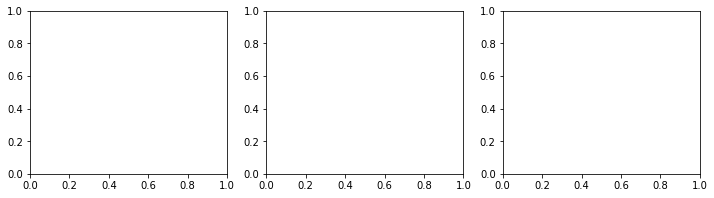

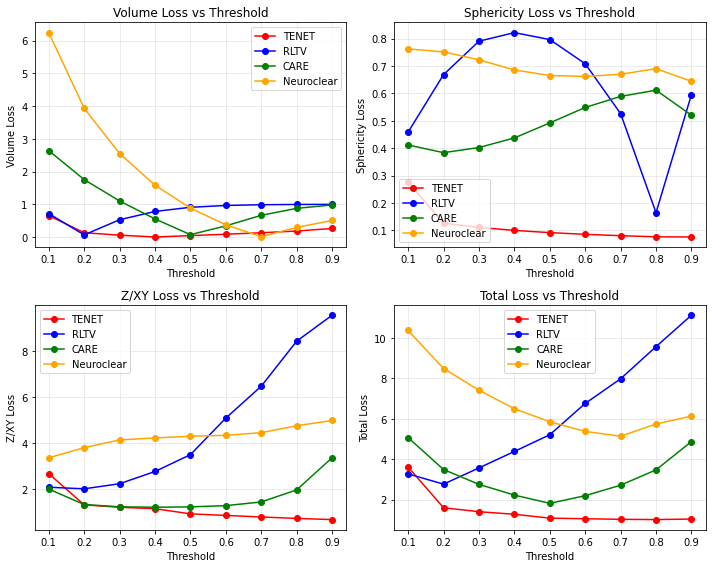

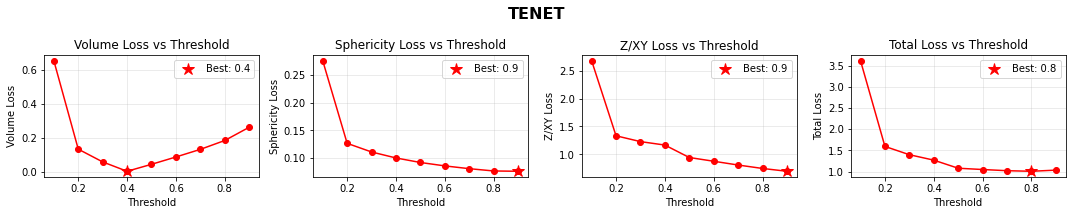

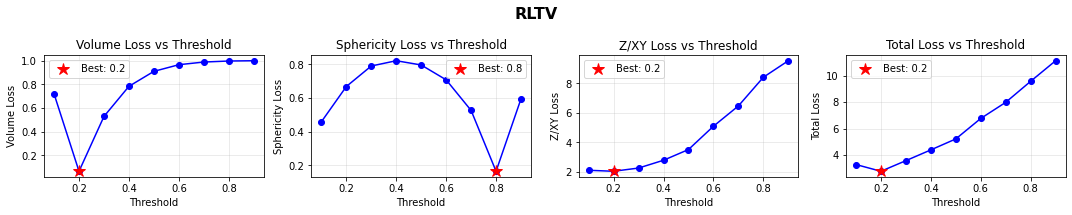

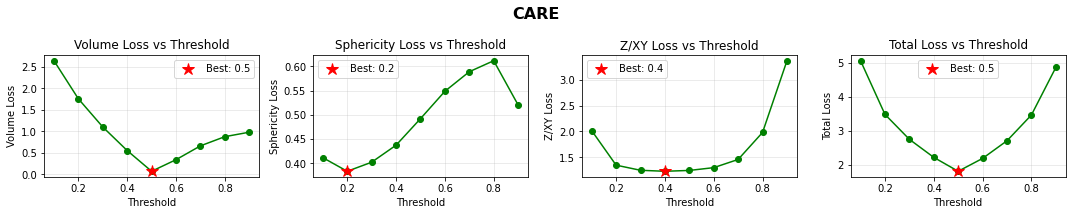

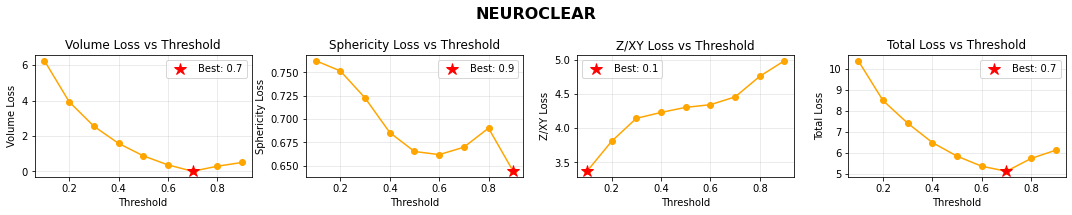


=== Optimal thresholds (by minimum total loss) ===

TENET:
  Optimal threshold: 0.8
  Volume: 3.415 (loss: 0.184)
  Sphericity: 0.924 (loss: 0.076)
  Z/XY Ratio: 1.745 (loss: 0.745)
  Total Loss: 1.006

RLTV:
  Optimal threshold: 0.2
  Volume: 3.909 (loss: 0.066)
  Sphericity: 0.332 (loss: 0.668)
  Z/XY Ratio: 3.027 (loss: 2.027)
  Total Loss: 2.762

CARE:
  Optimal threshold: 0.5
  Volume: 4.496 (loss: 0.074)
  Sphericity: 0.508 (loss: 0.492)
  Z/XY Ratio: 2.245 (loss: 1.245)
  Total Loss: 1.811

NEUROCLEAR:
  Optimal threshold: 0.7
  Volume: 4.141 (loss: 0.011)
  Sphericity: 0.330 (loss: 0.670)
  Z/XY Ratio: 5.455 (loss: 4.455)
  Total Loss: 5.135


In [35]:
methods = ['TENET', 'RLTV', 'CARE', 'Neuroclear']
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
colors = ['red', 'blue', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for method_idx, method_name in enumerate(methods):
    axes[0, 0].plot(thresholds, volume_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Volume Loss')
axes[0, 0].set_title('Volume Loss vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for method_idx, method_name in enumerate(methods):
    axes[0, 1].plot(thresholds, sphericity_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Sphericity Loss')
axes[0, 1].set_title('Sphericity Loss vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for method_idx, method_name in enumerate(methods):
    axes[1, 0].plot(thresholds, z_xy_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Z/XY Loss')
axes[1, 0].set_title('Z/XY Loss vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for method_idx, method_name in enumerate(methods):
    axes[1, 1].plot(thresholds, total_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title('Total Loss vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for method_idx, method_name in enumerate(methods):

    best_vol_loss_idx = np.argmin(volume_loss_mean[method_idx])
    best_vol_loss_thresh = thresholds[best_vol_loss_idx]
    
    best_sph_loss_idx = np.argmin(sphericity_loss_mean[method_idx])
    best_sph_loss_thresh = thresholds[best_sph_loss_idx]
    
    best_zxy_loss_idx = np.argmin(z_xy_loss_mean[method_idx])
    best_zxy_loss_thresh = thresholds[best_zxy_loss_idx]

    best_total_loss_idx = np.argmin(total_loss_mean[method_idx])
    best_total_loss_thresh = thresholds[best_total_loss_idx]
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    fig.suptitle(method_name.upper(), fontsize=16, fontweight='bold')
    
    axes[0].plot(thresholds, volume_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[0].plot(best_vol_loss_thresh, volume_loss_mean[method_idx, best_vol_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_vol_loss_thresh:.1f}')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Volume Loss')
    axes[0].set_title('Volume Loss vs Threshold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(thresholds, sphericity_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[1].plot(best_sph_loss_thresh, sphericity_loss_mean[method_idx, best_sph_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_sph_loss_thresh:.1f}')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Sphericity Loss')
    axes[1].set_title('Sphericity Loss vs Threshold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    axes[2].plot(thresholds, z_xy_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[2].plot(best_zxy_loss_thresh, z_xy_loss_mean[method_idx, best_zxy_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_zxy_loss_thresh:.1f}')
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('Z/XY Loss')
    axes[2].set_title('Z/XY Loss vs Threshold')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    axes[3].plot(thresholds, total_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[3].plot(best_total_loss_thresh, total_loss_mean[method_idx, best_total_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_total_loss_thresh:.1f}')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Total Loss')
    axes[3].set_title('Total Loss vs Threshold')
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

print("\n=== Optimal thresholds (by minimum total loss) ===")
for method_idx, method_name in enumerate(methods):
    optimal_idx = np.argmin(total_loss_mean[method_idx])
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\n{method_name.upper()}:")
    print(f"  Optimal threshold: {optimal_threshold:.1f}")
    print(f"  Volume: {volume_mean[method_idx, optimal_idx]:.3f} (loss: {volume_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Sphericity: {sphericity_mean[method_idx, optimal_idx]:.3f} (loss: {sphericity_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Z/XY Ratio: {z_xy_ratio_mean[method_idx, optimal_idx]:.3f} (loss: {z_xy_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Total Loss: {total_loss_mean[method_idx, optimal_idx]:.3f}")

/tmp/ipykernel_503502/203973109.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


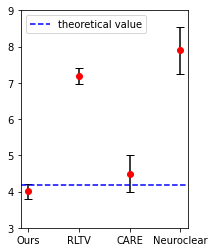

In [19]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.1) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.5) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.5) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
ax.set_yticks(np.arange(3, 10))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

/tmp/ipykernel_503502/3352337977.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


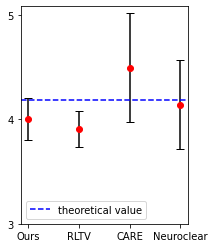

In [20]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.2) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.7) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.5) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
ax.set_yticks(np.arange(3, 6))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

In [21]:
print(mus, cis)

[4.00338333 3.90883333 4.4961875  4.14098333] [0.20182681 0.16864023 0.5217749  0.42369973]


/tmp/ipykernel_375060/1128437629.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


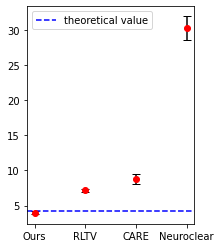

In [ ]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.1) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.1) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.3) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
#ax.set_yticks(np.arange(3, 32))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

In [ ]:
print(mus, cis)

[ 4.0034      7.197125    8.80140833 30.33274167] [0.20181265 0.22355524 0.75416576 1.68371748]


In [89]:
tenet      = tifffile.imread(path_of(base, "fig4", "tenet"     , idx))[0]
print(tenet.max())
print(tenet.min())

0.99997115
3.1769465e-14


In [108]:
get_best_threshold(care[:, 64], bit=16)

0

(array([26472.,   593.,   513.,   533.,   499.,   475.,   705.,   510.,
          284.,   136.]),
 array([0.        , 0.08875415, 0.1775083 , 0.26626244, 0.3550166 ,
        0.44377074, 0.5325249 , 0.621279  , 0.7100332 , 0.79878736,
        0.8875415 ], dtype=float32),
 <BarContainer object of 10 artists>)

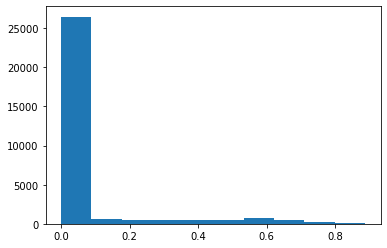

In [106]:
deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , 0))
deconv      = upsample3d(deconv/deconv.max(), scale=10)
deconv = np.clip(deconv, a_min=0,a_max=1)
plt.hist(care[:, 64].flatten(), bins=10)